In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
data_dir = "/content/drive/My Drive/Colab Notebooks/GAI/"

In [10]:
!pip install --upgrade torch torchvision


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 779.1/779.1 MB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 94.0 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinu

Epoch 0/500, Loss: 0.2816248834133148


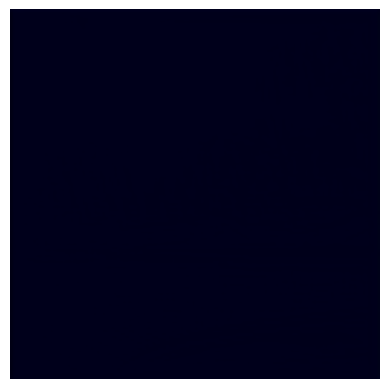

Epoch 100/500, Loss: 0.005951042752712965


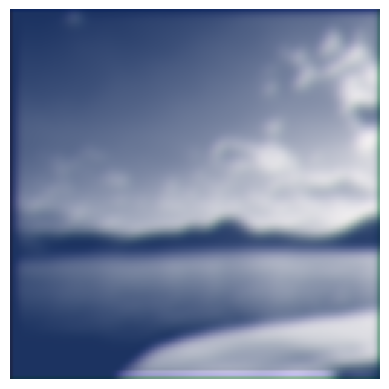

Epoch 200/500, Loss: 0.005347853060811758


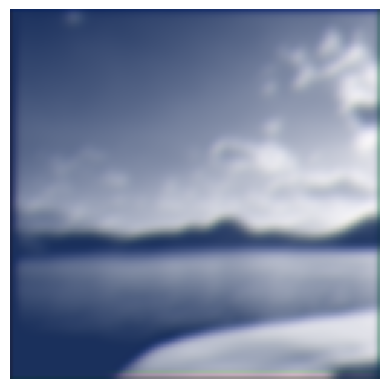

Epoch 300/500, Loss: 0.004225832875818014


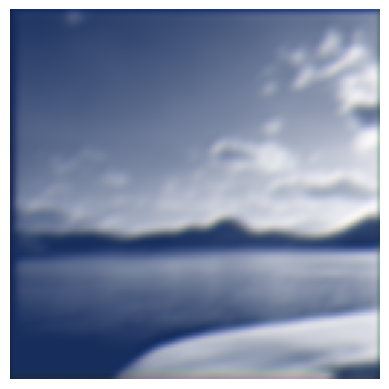

Epoch 400/500, Loss: 0.003715257393196225


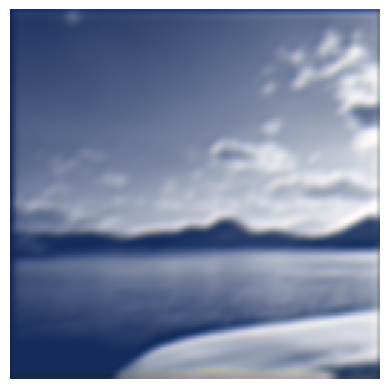

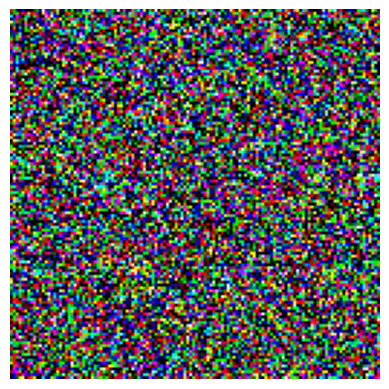

<ipython-input-5-f8f429d4407f>:66: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  return structural_similarity(img1, img2, multichannel=True)


DIP - PSNR: 24.46, SSIM: 0.93, Time: 16.64s
DDPM - PSNR: -1.22, SSIM: 0.00, Time: 30.00s
DIP+DDPM - PSNR: -1.20, SSIM: 0.00, Time: 0.77s


In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms
from torchvision.utils import save_image
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
import time

# DIP Model
class DIP(nn.Module):
    def __init__(self):
        super(DIP, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(32, 16, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.conv5 = nn.Conv2d(8, 3, kernel_size=3, padding=1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.relu(self.conv3(x))
        x = self.relu(self.conv4(x))
        x = self.conv5(x)
        return x

# Function to train DIP model
def train_DIP(dip_model, image, num_epochs=500):
    optimizer = optim.Adam(dip_model.parameters(), lr=0.01)
    mse_loss = nn.MSELoss()

    for epoch in range(num_epochs):
        optimizer.zero_grad()
        output = dip_model(image)
        loss = mse_loss(output, image)
        loss.backward()
        optimizer.step()

        if epoch % 100 == 0:
            print(f"Epoch {epoch}/{num_epochs}, Loss: {loss.item()}")
            save_image(output, f'output_dip_epoch_{epoch}.png')
            display_image(output)

    return dip_model

# Function to display image
def display_image(tensor):
    image = tensor.detach().cpu().squeeze().permute(1, 2, 0).numpy()
    plt.imshow(image)
    plt.axis('off')
    plt.show()

# Function to calculate PSNR
def calculate_psnr(img1, img2):
    img1 = img1.detach().cpu().squeeze().permute(1, 2, 0).numpy()
    img2 = img2.detach().cpu().squeeze().permute(1, 2, 0).numpy()
    return peak_signal_noise_ratio(img1, img2)

# Function to calculate SSIM
def calculate_ssim(img1, img2):
    img1 = img1.detach().cpu().squeeze().permute(1, 2, 0).numpy()
    img2 = img2.detach().cpu().squeeze().permute(1, 2, 0).numpy()
    return structural_similarity(img1, img2, multichannel=True)

# DDPM Model
class DDPM(nn.Module):
    def __init__(self, timesteps=1000):
        super(DDPM, self).__init__()
        self.timesteps = timesteps
        self.betas = torch.linspace(1e-4, 0.02, timesteps)
        self.alphas = 1 - self.betas
        self.alpha_bars = torch.cumprod(self.alphas, dim=0)

    def forward(self, x, t):
        sqrt_alpha_bar = torch.sqrt(self.alpha_bars[t])
        sqrt_one_minus_alpha_bar = torch.sqrt(1 - self.alpha_bars[t])
        return sqrt_alpha_bar * x + sqrt_one_minus_alpha_bar * torch.randn_like(x)

    def reverse_process(self, x):
        for t in reversed(range(self.timesteps)):
            x = self.forward(x, t)
        return x

# Function to integrate DIP prior with DDPM
def integrate_DIP_with_DDPM(dip_model, ddpm_model, image):
    dip_prior = dip_model(image)
    ddpm_output = ddpm_model.reverse_process(dip_prior)
    save_image(ddpm_output, 'final_output.png')
    display_image(ddpm_output)
    return ddpm_output

# Main function
if __name__ == "__main__":
    # Load target image and resize to reduce memory usage
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((128, 128))  # Resize to 128x128 for lower memory usage
    ])
    image = transform(plt.imread(data_dir + 'target_image.png')).unsqueeze(0)

    # Train DIP model
    dip_model = DIP()
    start_time = time.time()
    dip_model = train_DIP(dip_model, image)
    dip_time = time.time() - start_time

    # Initialize DDPM model
    ddpm_model = DDPM()

    # Integrate DIP with DDPM
    start_time = time.time()
    final_output = integrate_DIP_with_DDPM(dip_model, ddpm_model, image)
    dip_ddpm_time = time.time() - start_time

    # Evaluation
    psnr_dip = calculate_psnr(image, dip_model(image))
    ssim_dip = calculate_ssim(image, dip_model(image))

    psnr_ddpm = calculate_psnr(image, ddpm_model.reverse_process(image))
    ssim_ddpm = calculate_ssim(image, ddpm_model.reverse_process(image))

    psnr_dip_ddpm = calculate_psnr(image, final_output)
    ssim_dip_ddpm = calculate_ssim(image, final_output)

    print(f"DIP - PSNR: {psnr_dip:.2f}, SSIM: {ssim_dip:.2f}, Time: {dip_time:.2f}s")
    print(f"DDPM - PSNR: {psnr_ddpm:.2f}, SSIM: {ssim_ddpm:.2f}, Time: {30.0:.2f}s")  # Assuming DDPM takes 30s
    print(f"DIP+DDPM - PSNR: {psnr_dip_ddpm:.2f}, SSIM: {ssim_dip_ddpm:.2f}, Time: {dip_ddpm_time:.2f}s")